# Importing necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install pandas_profiling
!pip3 install catboost

ERROR: Could not find a version that satisfies the requirement pandas_profiling (from versions: none)
ERROR: No matching distribution found for pandas_profiling
ERROR: Could not find a version that satisfies the requirement catboost (from versions: none)
ERROR: No matching distribution found for catboost


In [22]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler

# Importing Data from Kaggle "SWELL" Dataset.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Stress Prediction Project/wearableDeviceSimulation.csv')

In [5]:
df

,heartRate,hrv,respiratoryRate,skinConductance,bodyMovement_X,bodyMovement_Y,bodyMovement_Z,sleepDuration,sleepEfficiency,activeEnergyBurned,standHours,ambientNoiseLevel
0,77.0,73.330163,17.0,3.032591,0.554356,0.611279,0.864110,7.360947,95.000000,577.0,9.0,35.367806
1,79.0,100.000000,17.0,20.000000,-0.617943,0.330026,0.512680,6.206326,95.000000,164.0,9.0,56.148999
2,63.0,100.000000,15.0,3.393093,0.511664,-2.110653,0.126309,7.834402,95.000000,221.0,8.0,55.165089
3,84.0,100.000000,17.0,2.893341,0.480502,-1.621983,0.248378,8.188804,68.263903,599.0,5.0,13.431971
4,77.0,100.000000,16.0,3.513293,-0.380487,0.818559,0.154682,9.275726,60.000000,329.0,10.0,17.597272
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,78.0,48.767456,16.0,1.055578,-0.133454,-1.870928,0.608481,4.989384,95.000000,466.0,3.0,11.854969
199996,66.0,84.741853,16.0,12.445460,-1.133714,-0.909503,0.341703,8.514938,95.000000,219.0,0.0,33.597585
199997,63.0,100.000000,16.0,3.998867,-1.395367,1.987187,-0.509070,7.970941,95.000000,483.0,3.0,20.312550
199998,56.0,96.345479,17.0,5.040160,-0.792141,-0.420040,1.906793,7.878908,95.000000,309.0,2.0,75.896050


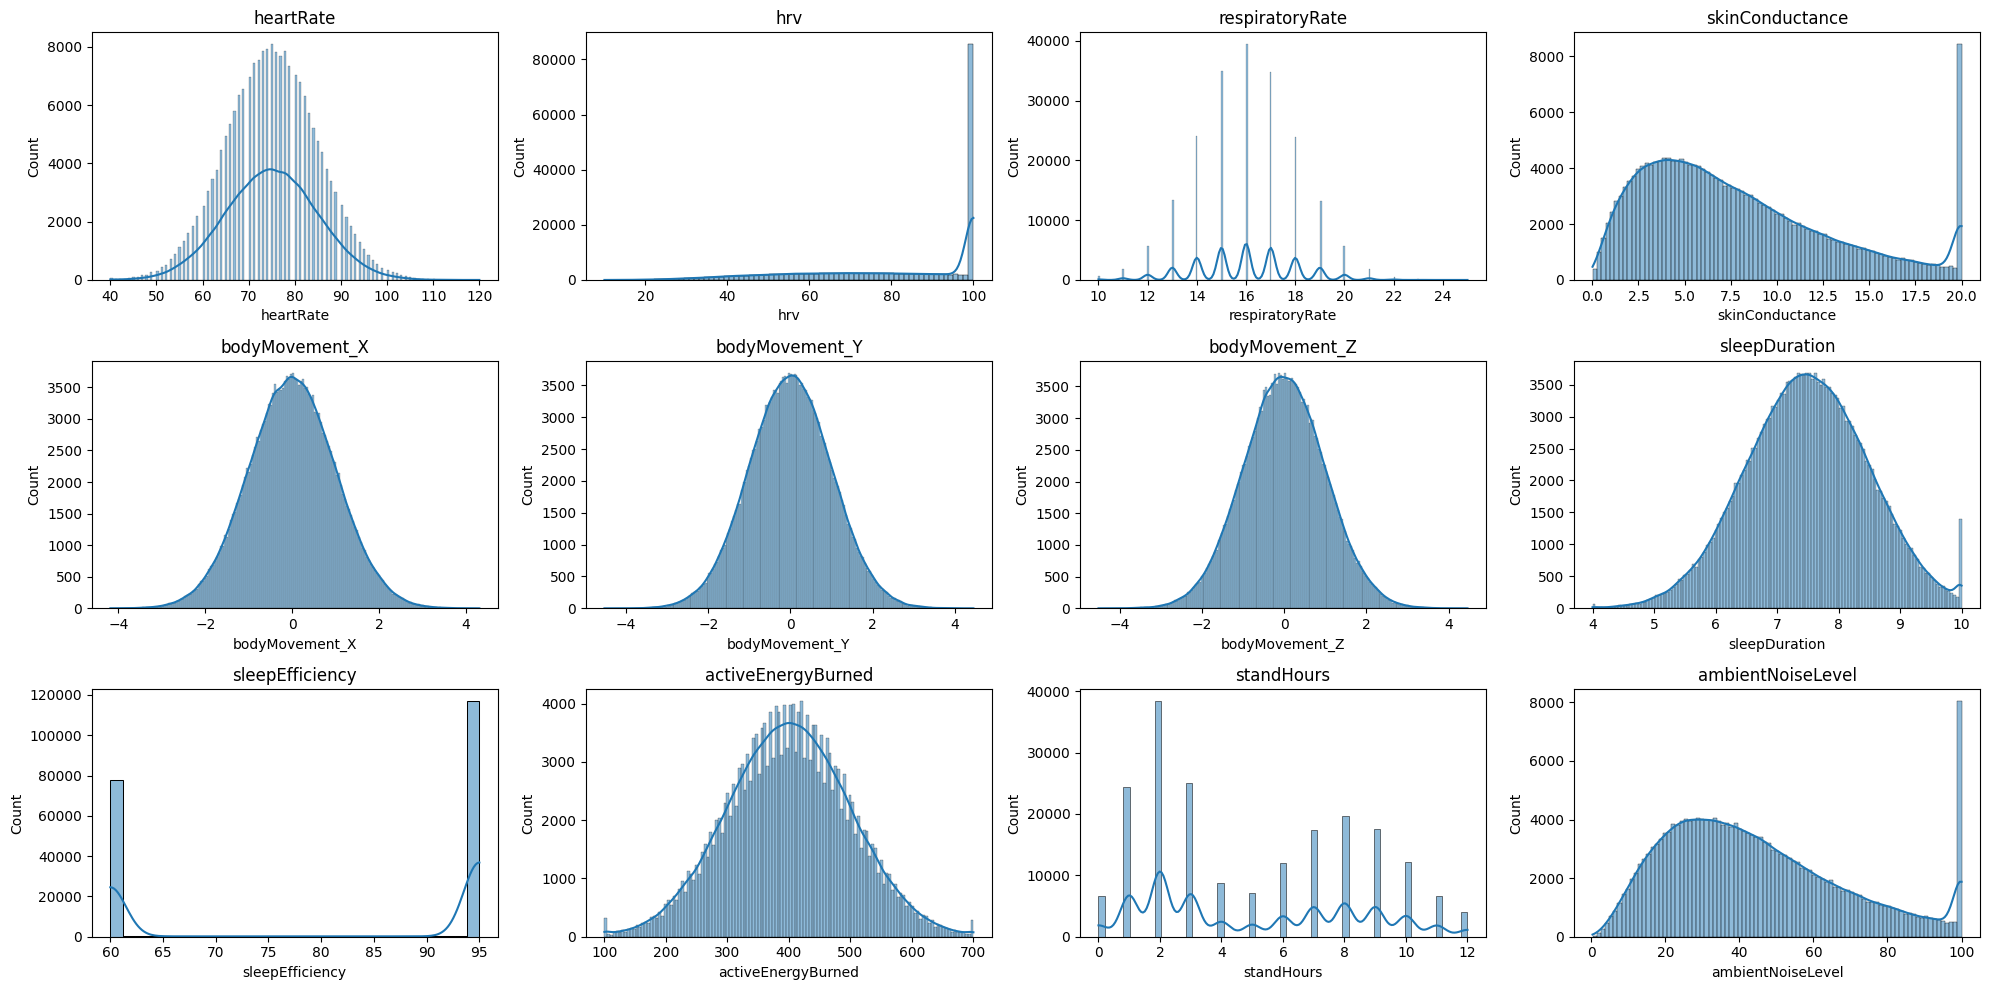

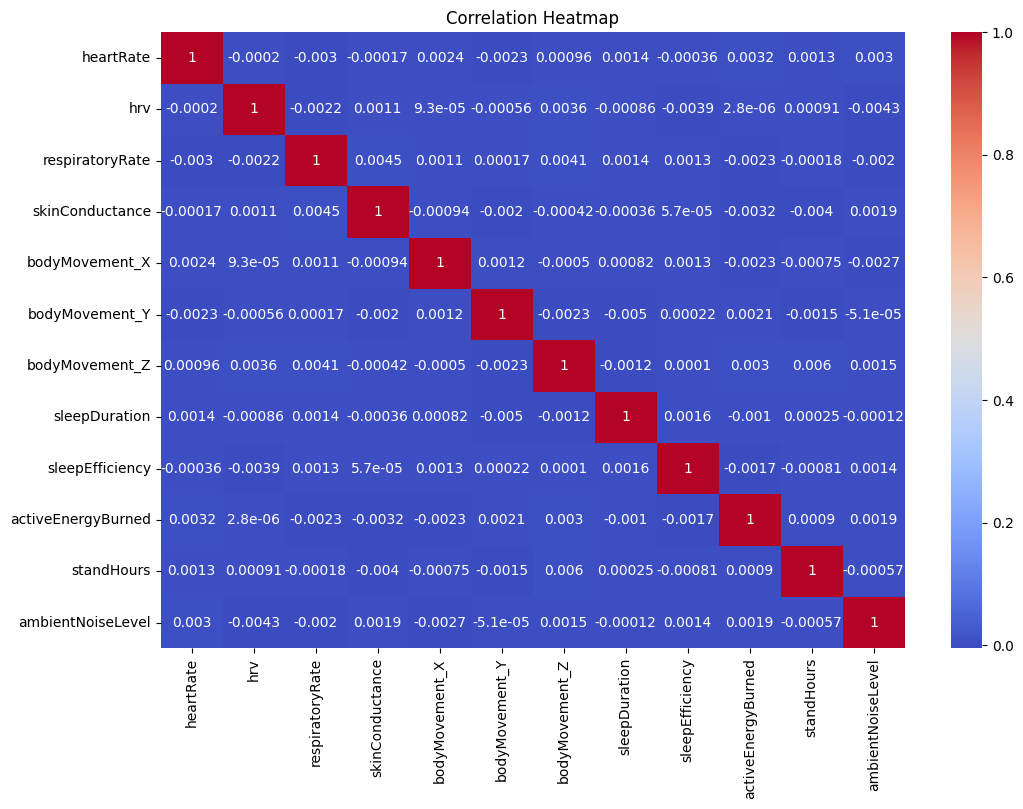

In [6]:
# Visualize the distribution of each feature
plt.figure(figsize=(20, 10))
for i, column in enumerate(df.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(data=df, x=column, kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# Visualize the correlations between features using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [7]:
weights = {
    'heartRate': 0.17,
    'hrv': 0.2,
    'respiratoryRate': 0.12,
    'skinConductance': 0.08,
    'bodyMovement_X': 0.05,
    'bodyMovement_Y': 0.05,
    'bodyMovement_Z': 0.05,
    'sleepDuration': 0.1,
    'sleepEfficiency': 0.08,
    'activeEnergyBurned': 0.1,
    'standHours': 0.05,
    'ambientNoiseLevel': 0.05
}

# Normalize the features
normalizedData = (df - df.min()) / (df.max() - df.min())

# Calculate the stress score
stressScore = np.dot(normalizedData[list(weights.keys())].values, np.array(list(weights.values())))

# Create the stress column in the DataFrame
df['stress'] = stressScore

In [8]:
df.describe()

,heartRate,hrv,respiratoryRate,skinConductance,bodyMovement_X,bodyMovement_Y,bodyMovement_Z,sleepDuration,sleepEfficiency,activeEnergyBurned,standHours,ambientNoiseLevel,stress
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000
mean,74.980095,81.071620,15.997965,7.809337,-0.000866,-0.002520,0.000267,7.498065,80.920179,399.988505,5.00197,44.196911,0.585411
std,9.983321,21.646327,2.024685,5.070342,1.000569,1.001337,1.000413,0.996205,17.003094,100.007876,3.38484,23.811086,0.076972
min,40.000000,10.000000,10.000000,0.012295,-4.187408,-4.530373,-4.515535,4.000000,60.000000,100.000000,0.00000,0.336639,0.272180
25%,68.000000,64.318002,15.000000,3.847936,-0.674457,-0.680248,-0.671352,6.823512,60.000000,332.000000,2.00000,25.784072,0.533805
50%,75.000000,90.108137,16.000000,6.710859,-0.002164,-0.001478,-0.000863,7.498731,95.000000,400.000000,4.00000,40.050543,0.588764
75%,82.000000,100.000000,17.000000,10.755437,0.671997,0.672289,0.674652,8.178492,95.000000,467.000000,8.00000,58.668946,0.640950
max,120.000000,100.000000,25.000000,20.000000,4.308658,4.455984,4.459733,10.000000,95.000000,700.000000,12.00000,100.000000,0.852881


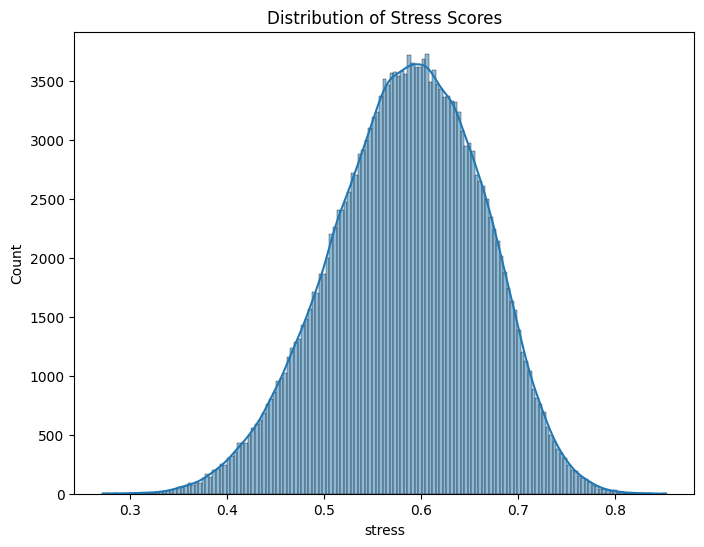

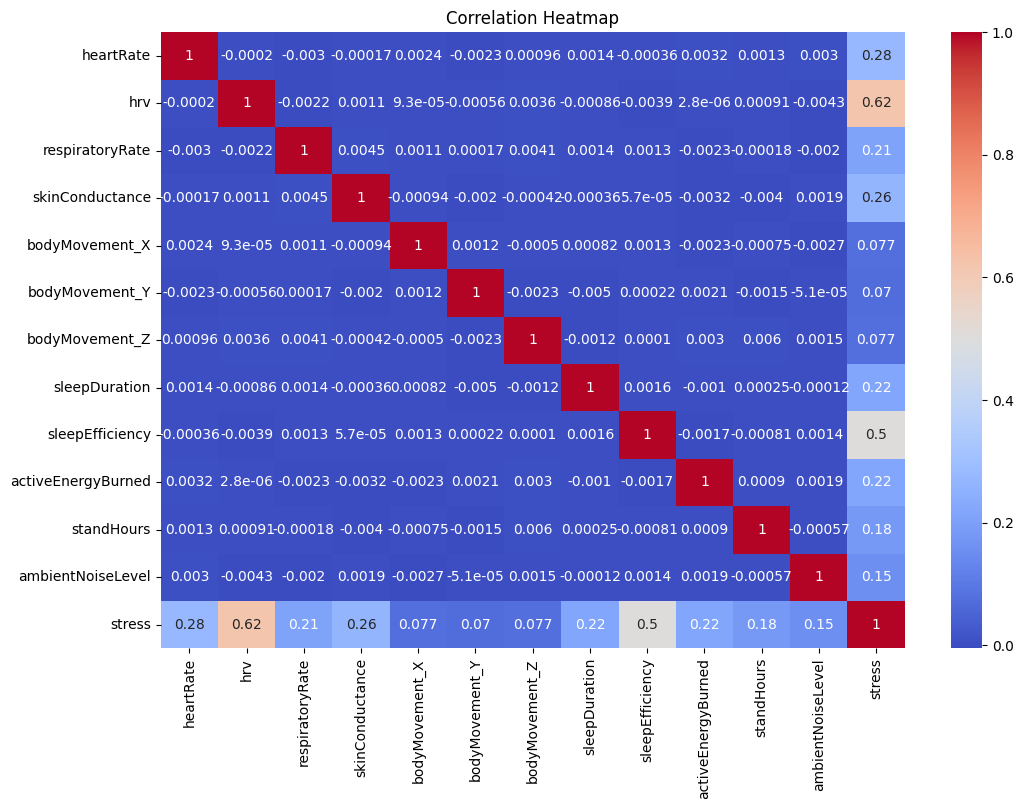

In [9]:
# Explore the distribution of stress scores
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='stress', kde=True)
plt.title("Distribution of Stress Scores")
plt.show()

# Visualize the correlations between features using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [10]:
def categorize_stress(rate):
    if rate <= 0.55:
        return 'no-stress'
    elif 0.55 < rate <= 0.75:
        return 'mild stress'
    else:
        return 'severe stress'

df['stress_category'] = df['stress'].apply(categorize_stress)

<BarContainer object of 3 artists>

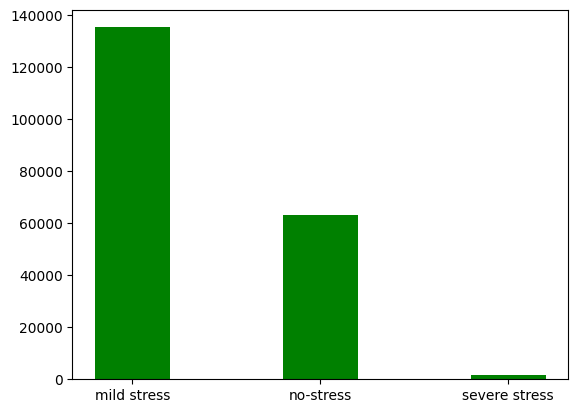

In [11]:
conditions = dict(df['stress_category'].value_counts())
labels = list(conditions.keys())
counts = list(conditions.values())
plt.bar(labels,counts, color ='green',
        width = 0.4)

In [12]:
le = preprocessing.LabelEncoder()
df['stress_category_encoded'] = le.fit_transform(df['stress_category'])

In [13]:
df.groupby(['stress_category']).count()['stress']

stress_category
mild stress      135329
no-stress         63089
severe stress      1582
Name: stress, dtype: int64

In [14]:
# Define the features and target variable
features = ['heartRate', 'hrv', 'respiratoryRate', 'skinConductance', 'bodyMovement_X',
            'bodyMovement_Y', 'bodyMovement_Z', 'sleepDuration', 'sleepEfficiency',
            'activeEnergyBurned', 'standHours', 'ambientNoiseLevel', 'stress_category_encoded']

# Split the data into training and testing sets
train, test = train_test_split(df[features], test_size=0.2, random_state=42)


In [15]:

# Perform data normalization
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Analysing Data using Pandas Profiling

In [16]:
#profile = pp.ProfileReport(train)
#profile.to_file("output.html")

# Plotting Pearson's Correlation Matrix to check dependency of variables

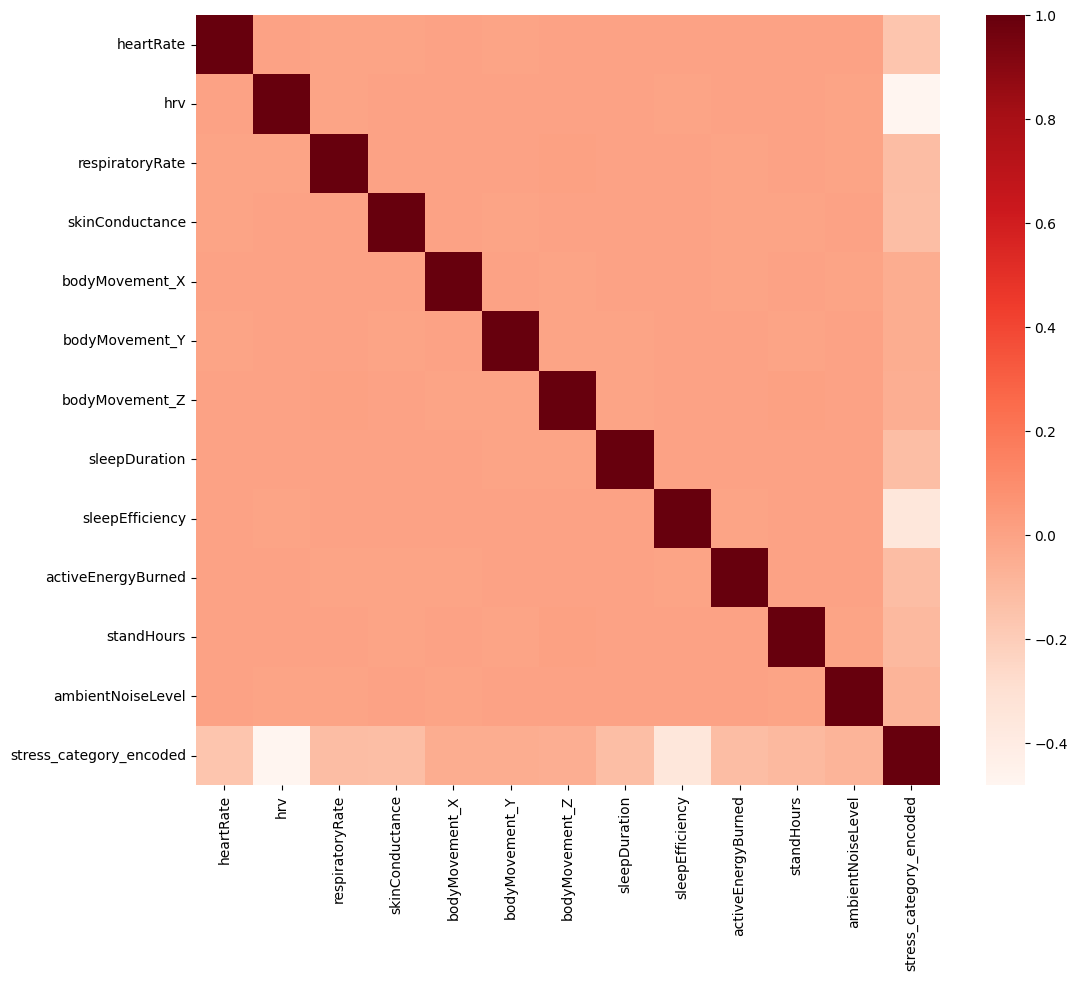

In [17]:
plt.figure(figsize=(12,10))
corr = train.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

# Defining a feature selection function

This function selects features which have a positive pearson's correlation with "condition" column of data. A suitable threshold is set for selcting such features.

In [18]:
df.columns

Index(['heartRate', 'hrv', 'respiratoryRate', 'skinConductance',
       'bodyMovement_X', 'bodyMovement_Y', 'bodyMovement_Z', 'sleepDuration',
       'sleepEfficiency', 'activeEnergyBurned', 'standHours',
       'ambientNoiseLevel', 'stress', 'stress_category',
       'stress_category_encoded'],
      dtype='object')

In [19]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]


In [20]:
X_test = test[X_train.columns]
y_test = test['stress_category_encoded']

X_train.head()
X_test.head()

,heartRate,hrv,respiratoryRate,skinConductance,bodyMovement_X,bodyMovement_Y,bodyMovement_Z,sleepDuration,sleepEfficiency,activeEnergyBurned,standHours,ambientNoiseLevel
119737,69.0,100.000000,19.0,3.121438,0.924386,-1.251811,0.705994,6.881158,60.0,287.0,2.0,70.538083
72272,82.0,71.867483,16.0,1.277554,-0.439108,0.793797,0.425621,6.600801,60.0,433.0,7.0,44.077926
158154,62.0,100.000000,17.0,20.000000,0.305701,-0.447774,-0.747273,8.059973,95.0,391.0,1.0,74.667767
65426,63.0,100.000000,15.0,7.079080,0.129414,1.041712,1.748381,9.170242,60.0,411.0,7.0,45.588150
30074,74.0,100.000000,16.0,6.240716,-2.526721,-1.489778,-1.406521,6.237240,60.0,439.0,10.0,83.499528


GaussianNB()
LogisticRegression()
RandomForestClassifier()
MLPClassifier()
Proba [[2.06031629e-01 7.93968367e-01 3.73709859e-09]
 [4.92230742e-05 9.99950777e-01 3.37674908e-11]
 [9.99997579e-01 2.06149227e-12 2.42064617e-06]
 ...
 [9.99543467e-01 4.55711546e-04 8.21882125e-07]
 [9.45610457e-01 5.43895424e-02 4.42552685e-10]
 [9.99999892e-01 1.07292532e-07 7.39209909e-10]]
Proba [[6.31934540e-01 3.68065460e-01 3.28628615e-40]
 [3.84860061e-01 6.15139939e-01 1.49117157e-53]
 [8.90196176e-01 5.97835819e-03 1.03825466e-01]
 ...
 [5.96887390e-01 4.03112610e-01 7.97169142e-65]
 [7.13348048e-01 2.86651952e-01 1.88840148e-39]
 [9.08724759e-01 9.12752407e-02 4.63822232e-14]]
Proba [[8.48581473e-02 9.15141853e-01 2.34840545e-21]
 [6.75057455e-12 1.00000000e+00 2.31165854e-34]
 [9.99998991e-01 5.58736642e-39 1.00880989e-06]
 ...
 [1.00000000e+00 1.68405081e-10 1.90751621e-15]
 [9.96955615e-01 3.04438478e-03 8.19212822e-19]
 [1.00000000e+00 2.20304046e-20 6.16481867e-13]]


<ipython-input-24-c33dc7be2031>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-24-c33dc7be2031>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-24-c33dc7be2031>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


Proba [[0.31 0.69 0.  ]
 [0.15 0.85 0.  ]
 [0.99 0.   0.01]
 ...
 [0.64 0.36 0.  ]
 [0.85 0.15 0.  ]
 [0.97 0.03 0.  ]]
Proba [[7.03455979e-05 9.99929654e-01 1.41873220e-33]
 [2.97497563e-51 1.00000000e+00 2.65246191e-51]
 [1.00000000e+00 2.29660167e-63 6.12904064e-32]
 ...
 [1.00000000e+00 3.21775199e-26 6.00136136e-42]
 [1.00000000e+00 2.94531900e-13 3.50397556e-31]
 [1.00000000e+00 6.54607345e-42 6.08483041e-41]]


<ipython-input-24-c33dc7be2031>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-24-c33dc7be2031>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


             Algorithm  F1 Score  Precision    Recall  Average AUC
0             CatBoost  0.991800   0.991800  0.991800     0.999546
1          Naive Bayes  0.905575   0.905575  0.905575     0.989132
2  Logistic Regression  0.999100   0.999100  0.999100     0.999963
3                  RFC  0.947600   0.947600  0.947600     0.980529
4                  MLP  0.997325   0.997325  0.997325     0.999851 
 <-------------------------------------------------->


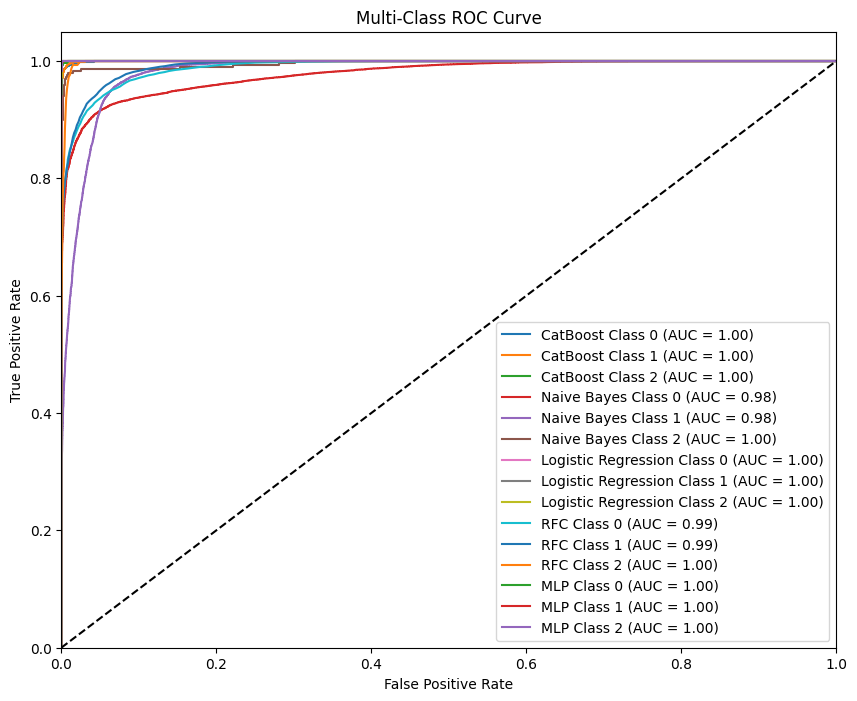

Bagging Ensemble Method Performance Metrics 

 F1 Score: 0.930425 
 Precision: 0.930425 
 Recall: 0.930425 

 <-------------------------------------------------->



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Ensemble Method Performance Metrics 

 F1 Score: 0.999275 
 Precision: 0.999275 
 Recall: 0.999275 



In [24]:
# Assuming you have loaded your dataset into a pandas DataFrame with features and labels.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# List of machine learning algorithms to consider
algorithms = [
    ('CatBoost', CatBoostClassifier(task_type="GPU", devices='0:1', silent=True), {}),
    ('Naive Bayes', GaussianNB(), {}),
    ('Logistic Regression', LogisticRegression(), {}),
    ('RFC', RandomForestClassifier(), {}),
    #('SVM', SVC(kernel='linear', probability=True, decision_function_shape='ovr'), {}),
    ('MLP', MLPClassifier(), {})
]

# Train base models
base_models = {}
for algorithm_name, algorithm, _ in algorithms:
    print(algorithm)
    model = algorithm
    model.fit(X_train, y_train)
    base_models[algorithm_name] = model

eval_metrics = ['F1 Score', 'Precision', 'Recall', 'Average AUC']
results = pd.DataFrame(columns=['Algorithm'] + eval_metrics)

for algorithm_name, model in base_models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')

    if hasattr(model, "predict_proba"):
        probas = model.predict_proba(X_test)
        print('Proba', probas)
        macro_roc_auc_ovo = roc_auc_score(y_test, probas, multi_class="ovo", average="macro")
    else:
        macro_roc_auc_ovo = 'NA'

    results = results.append({
        'Algorithm': algorithm_name,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Average AUC': macro_roc_auc_ovo
    }, ignore_index=True)

print(results, '\n <-------------------------------------------------->')

plt.figure(figsize=(10, 8))

for algorithm_name, model in base_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        for i in range(len(np.unique(y_test))):
            fpr, tpr, _ = roc_curve(y_test, y_score[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f"{algorithm_name} Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Ensembling using Bagging with all base models
bagging_model = BaggingClassifier(base_estimator=None, n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_y_pred = bagging_model.predict(X_test)
bagging_f1 = f1_score(y_test, bagging_y_pred, average='micro')
bagging_precision = precision_score(y_test, bagging_y_pred, average='micro')
bagging_recall = recall_score(y_test, bagging_y_pred, average='micro')
print(f"Bagging Ensemble Method Performance Metrics \n\n \
F1 Score: {bagging_f1} \n \
Precision: {bagging_precision} \n \
Recall: {bagging_recall} \n\n <-------------------------------------------------->\n")

# Ensembling using Stacking
meta_model = LogisticRegression(multi_class='ovr')
stacking_model = StackingClassifier(estimators=list(base_models.items()), final_estimator=meta_model)
stacking_model.fit(X_train, y_train)
stacking_y_pred = stacking_model.predict(X_test)
stacking_f1 = f1_score(y_test, stacking_y_pred, average='micro')
stacking_precision = precision_score(y_test, stacking_y_pred, average='micro')
stacking_recall = recall_score(y_test, stacking_y_pred, average='micro')
print(f"Stacking Ensemble Method Performance Metrics \n\n \
F1 Score: {stacking_f1} \n \
Precision: {stacking_precision} \n \
Recall: {stacking_recall} \n")

#print(f"Stacking F1 Score: {stacking_f1}")
